# Time Series Analysis for Stock Price Prediction

__Key Takeaways__:
By the end of this module, you will gain a comprehensive understanding of time series analysis techniques and their application in forecasting stock prices. You will be equipped with practical skills to build and evaluate time series models using real-world financial data.

## Prepare Data

### Libraries

In [164]:
# libraries
import pandas as pd
import numpy as np

# API to access stock data
# import pytimetk as tk
import yfinance as yf
import pandas_datareader as pdr

from xgboost import XGBRegressor

# For time series modeling
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error # Evaluation

# Visualization
import matplotlib.pyplot as plt 
import plotly.express as px

from datetime import datetime, timedelta, date

# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=Warning)

### Import

In [146]:
symbol = 'AAPL'

In [147]:
# Data from Google Finance  
stock_price = yf.download(symbol, start=start_date, end=end_date)
stock_price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-09,173.050003,173.539993,171.600006,171.770004,170.858017,45326900
2023-05-10,173.020004,174.029999,171.899994,173.559998,172.638504,53724500
2023-05-11,173.850006,174.589996,172.169998,173.750000,172.827515,49514700
2023-05-12,173.619995,174.059998,171.000000,172.570007,171.891205,45497800
2023-05-15,173.160004,173.210007,171.470001,172.070007,171.393173,37266700


### Explore

In [148]:
today = date.today()

start_date = today - timedelta(days=365) # 5 years of data
start_date

datetime.date(2023, 5, 9)

In [149]:
# Create prepare_data function
def prepare_data(symbol):

    today = date.today()

    start_date = today - timedelta(days=365*5) # 5 years of data
    end_date = today

    # download stock price
    data = yf.download(symbol, start=start_date, end=end_date)

    # filter Adj Close
    data = data[['Adj Close']]

    # Rename Adj Close
    data = data.rename(columns={'Adj Close': 'price'})

    # Movivng Average 20, 50
    data['ma_20'] = data['price'].rolling(window=20).mean()
    data['ma_50'] = data['price'].rolling(window=50).mean()

    # Calculate returns
    data['daily_returns'] = data['price'].pct_change()*100

    # Drop NaNs
    data.dropna(inplace=True)

    return data

$R_t$ - returns
$$R_t = (P_1 - P_0)/P_0$$



In [150]:
(72.349129 - 73.059418)/73.059418*100

-0.9722073066609823

In [151]:
# Calling the function
df = prepare_data(symbol)
df.info()
df.head()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1208 entries, 2019-07-22 to 2024-05-07
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          1208 non-null   float64
 1   ma_20          1208 non-null   float64
 2   ma_50          1208 non-null   float64
 3   daily_returns  1208 non-null   float64
dtypes: float64(4)
memory usage: 47.2 KB


,price,ma_20,ma_50,daily_returns
Date,,,,
2019-07-22,50.064674,48.834923,46.735453,2.285386
2019-07-23,50.456059,48.958864,46.791794,0.781757
2019-07-24,50.414989,49.117112,46.902689,-0.081396
2019-07-25,50.016354,49.204330,46.991405,-0.790709
2019-07-26,50.190308,49.300971,47.072680,0.347794


In [152]:
# filtering by date index
plot_data = df.loc['2023-01-01':'2023-12-31']

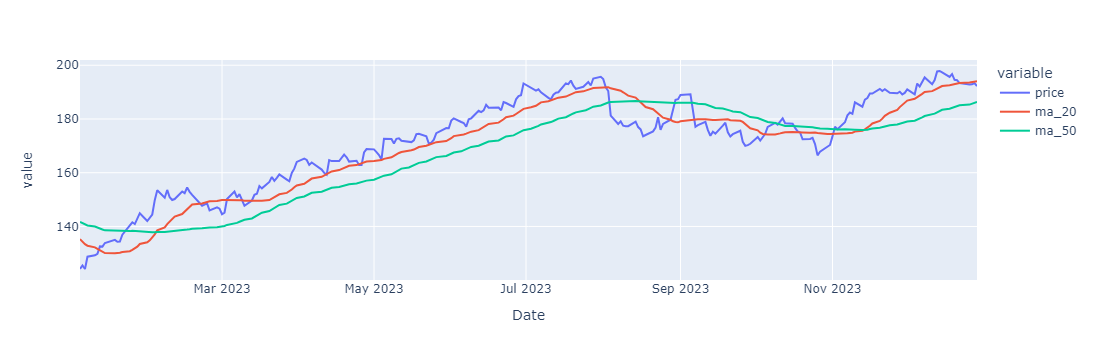

In [153]:
# plot time series
plt.Figure(figsize=(20,25))

fig = px.line(
    data_frame=plot_data, 
    x=plot_data.index, 
    y=['price', 'ma_20', 'ma_50']
)

# Display plot
fig.show()

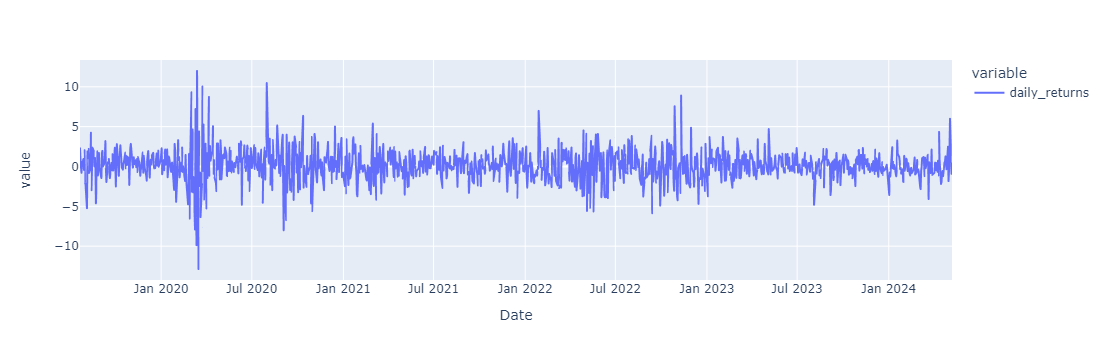

In [154]:
# plot returns
plt.Figure(figsize=(10,25))

fig = px.line(
    data_frame=df, 
    x=df.index, 
    y=['daily_returns']
)

# Display plot
fig.show()

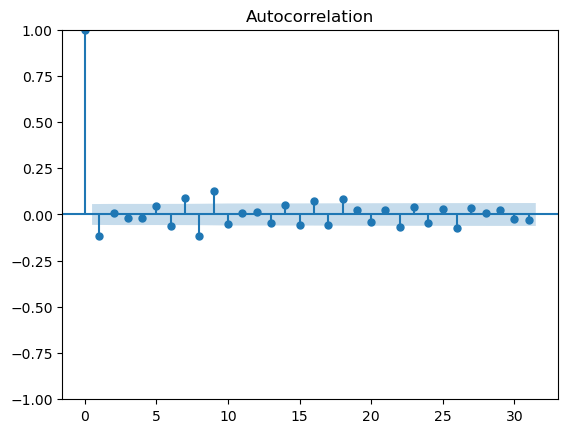

In [155]:
#  Daily returns are stationary at lag 0
# That tells us aabout the parameter p.
plot_acf(df.daily_returns);

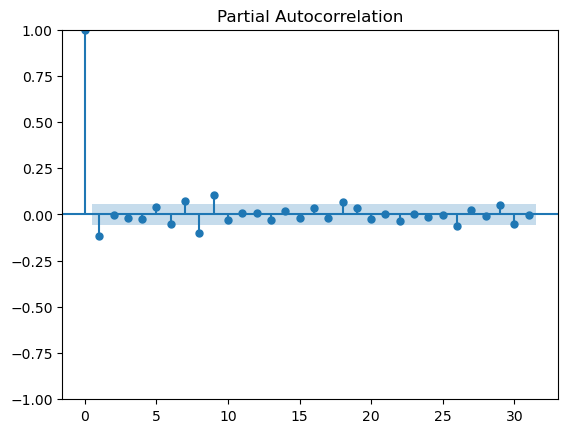

In [156]:
plot_pacf(df.daily_returns);

In [157]:
# Split the data into training and testing sets
cutoff = '2023-05-07'

df = df[['daily_returns']]

y_train = df.loc[:cutoff, :]
y_test = df.loc[cutoff:, :]

print(f'Train: {y_train.shape} Test: {y_test.shape}')

Train: (956, 1) Test: (252, 1)


### Split

## Build Model

### Baseline

In [158]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print(f'MAE: {mae_baseline}')

MAE: 1.5590006101286034


### Iterate

In [176]:
# Model fitting
#  p - AR
#  q - MA
model = arch_model(y_train, p=1, q=0, rescale=False).fit()

# Summary of the model
model.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4375.087568644292
Iteration:      2,   Func. Count:     13,   Neg. LLF: 4455.8983918865715
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2116.844091587922
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2222.7670565851977
Iteration:      5,   Func. Count:     31,   Neg. LLF: 2063.0795530899004
Iteration:      6,   Func. Count:     35,   Neg. LLF: 2063.0736992396687
Iteration:      7,   Func. Count:     39,   Neg. LLF: 2063.0720494324623
Iteration:      8,   Func. Count:     43,   Neg. LLF: 2063.0720469576863
Iteration:      9,   Func. Count:     46,   Neg. LLF: 2063.072046957752
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2063.0720469576863
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:          daily_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2063.07
Distribution:                  Normal   AIC:                           4132.14
Method:            Maximum Likelihood   BIC:                           4146.73
                                        No. Observations:                  956
Date:                Wed, May 08 2024   Df Residuals:                      955
Time:                        11:19:28   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2114  6.867e-02      3.078  2.084e-03 [7.677e-02,  0.346]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          3.6093      0.325     11.109  1.129e-28   [  2.973,  4.246]
alpha[1]       0.2262  7.087e-02      3.191  1.417e-03 [8.725e-02,  0.365]
==========================================================================

Covariance estimator: robust
"""

### Evaluate

In [174]:
# Evaluation metrics
model.aic

4132.144093915373

In [175]:
# Evaluation metrics
model.bic

4146.732367654527

In [186]:
# Time series forecasting
model.forecast(horizon=1, reindex=False).mean

,h.1
Date,
2023-05-05,0.211357


## Communicate

In [187]:
# Plot the results
# Use data visualization libraries to display the forecasted results.

In [188]:
# FBprophet lib
# H2O.ai